<a href="https://colab.research.google.com/github/ace26597/Cutting-down-time-travel-to-mars/blob/main/EE_608_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# StarKicker - cutting down on travel time to Mars



# What is StarKicker

https://www.spacex.com/vehicles/starship/

The idea is to use a special desiged Starship (called here StarKicker) to provide additional Delta V to the departing to mars crewed Starship. Once launched, the StarKicker will always stay in orbit. The StarKicker is basen on expendable version of SpaceX's Starship but needs neither the nosecone nor the cargo bay. Both the nosecone and the cargo bay should be ditched during the launch. It utilize standard 9m ring docking port, that is used to connect SuperHeavy with the StarKicker on accent from earth.

Operation outline:

* Fully fuelled StarKicker docks with the departing StarShip
* Starship burns a large amount of fuel giving additional delta V to the departing Starship
* After the "kick burn" both Starships separate
* The StarKicker rotates 180° and burns retrograde to return to its original orbit
  * Optionally, StarKicker may return to higher elliptical orbit an use aerobreaking to reduce speed
* StarKicker gets refuelled in orbit
* StarKicker is ready for reuse

# What is the goal of the Notebook

The goal of this notebook is to calculate exact travel trajectories and times in order to understand the benefit of the Starship in terms of reducing travel time.

# Notebook structure

This notebook consists of the following parts:

* **Global definitions and imports**
  * Define nature constants
  * import python libraries
* **BSP solar system data from NASA**
  * Loading BSP-file from https://naif.jpl.nasa.gov
  * Providing methods to get solar system body locations and velocities
* **Plots**
  * Implements 3D and 2D ploting methods using `matplotlib.pyplot`
* **Mission profile**
  * Classes for mission profile definition
  * Specifies starting point and velocity, planned burns and separation events
* **Simulation**
  * Simulates StarShip flight according to the mission profile
  * Uses `scipy.integrate.ode` differential equation solver for possition, velocity and mass
  * Saves and returns flight data (`simulation_data` dict)
* **Optimizer**
  * Uses function optimizer `scipy.optimize.minimize` to find optimal trajectory


# Python

## Download packages

In [ ]:
%pip -q install jplephem 'pytest==5.4.3' pytest-sugar ipytest

     |████████████████████████████████| 40kB 4.9MB/s 
     |████████████████████████████████| 256kB 10.0MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


## Global definitions

**Python imports**

In [ ]:
from typing import List, Tuple

import math
import datetime
import numpy as np

from scipy.integrate import ode
from scipy.spatial.transform import Rotation
from scipy.optimize import minimize

from timeit import default_timer as timer

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from jplephem.spk import SPK # https://pypi.org/project/jplephem/

import pytest
import ipytest
ipytest.autoconfig(raise_on_error = True)

#np.set_printoptions(precision=10)
#np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

**Constants**

In [ ]:
# Celestial bodies
# (See de421.bsp)
SUN=0
MERCURY=1
VENUS=2
EARTH=3
MARS=4
JUPITER=5
SATURN=6
URANUS=7
NEPTUNE=8

PLANETS=[EARTH, MARS, JUPITER]
BODIES=[SUN] + PLANETS

ALL_PLANETS=[MERCURY, VENUS, EARTH, MARS, JUPITER, SATURN, URANUS, NEPTUNE]
ALL_BODIES=[SUN] + ALL_PLANETS

BODY_NAMES = {SUN: "Sun", MERCURY: "Mercury", VENUS: "Venus",
              EARTH: "Earth", MARS: "Mars", JUPITER: "Jupiter",
              SATURN: "Saturn", URANUS: "Uranus", NEPTUNE: "Neptune"}

# Standard gravitational parameter
MU_EARTH=398600.4418 # m^3/s^2
MU_MARS=42828.37
MU_SUN=1.32712440018e11
MU_JUPITER=1.26686534e8 #e8

MU = {SUN: MU_SUN, EARTH: MU_EARTH, MARS: MU_MARS, JUPITER: MU_JUPITER}


G_EARTH=9.80665e-3 # km/sec^2
R_EARTH=6378.0 # km at equator #radius of LEO
R_MARS=3396.2 # km at equator

ORBITAL_PERIOD = {
    SUN: 100,
    MERCURY: 88,
    VENUS: 225,
    EARTH: 366,
    MARS: 687,
    JUPITER: 4333,
    SATURN: 10759,
    URANUS: 10759,  # 30688  - no more data available
    NEPTUNE: 10759, # 60182  - no more data available
}

# StarShip data
RAPTOR_SPECIFIC_IMPULSE=382  # https://en.wikipedia.org/wiki/SpaceX_Raptor
RAPTOR_FLOW_RATE=0.9312 # Ton/sec, https://spaceflight101.com/spx/spacex-raptor/ 

Starship_RAPTOR_COUNT=3
STARSHIP_RAPTOR_COUNT=3

In [ ]:
class PrettyPrintable:
    def __repr__(self):
        return pretty_write_dict(self.__dict__)
            
def pretty_write_dict(dictionary):
    def _nested(obj, level=1):
        indentation_values = "\t" * level
        indentation_braces = "\t" * (level - 1)
        if isinstance(obj, PrettyPrintable):
            obj = obj.__dict__
        if isinstance(obj, dict):
            return "{\n%(body)s%(indent_braces)s}" % {
                "body": "".join("%(indent_values)s\'%(key)s\': %(value)s,\n" % {
                    "key": str(key),
                    "value": _nested(value, level + 1),
                    "indent_values": indentation_values
                } for key, value in obj.items()),
                "indent_braces": indentation_braces
            }
        if isinstance(obj, list):
            return "[\n%(body)s\n%(indent_braces)s]" % {
                "body": "".join("%(indent_values)s%(value)s,\n" % {
                    "value": _nested(value, level + 1),
                    "indent_values": indentation_values
                } for value in obj),
                "indent_braces": indentation_braces
            }
        else:
            return "\'%(value)s\'" % {"value": str(obj)}

    dict_text = _nested(dictionary)
    return dict_text

def self_assign(self, vars_to_add):
    self.__dict__.update(l for l in vars_to_add.items() if l[0] != 'self')

In [ ]:
def get_julian_datetime(date):
    #Convert a datetime object into julian float.
    
    if not isinstance(date, datetime.datetime):
        raise TypeError('Invalid type for parameter "date" - expecting datetime')
    elif date.year < 1801 or date.year > 2099:
        raise ValueError('Datetime must be between year 1801 and 2099')

    # Perform the calculation
    julian_datetime = 367 * date.year - int((7 * (date.year + int((date.month + 9) / 12.0))) / 4.0) + int(
        (275 * date.month) / 9.0) + date.day + 1721013.5 + (
                          date.hour + date.minute / 60.0 + date.second / math.pow(60,
                                                                                  2)) / 24.0 - 0.5 * math.copysign(
        1, 100 * date.year + date.month - 190002.5) + 0.5

    return julian_datetime

def get_julian_delta(delta_in_seconds: float):
    return delta_in_seconds / (60 * 60 * 24)

## Jet Propulsion Laboratory's SPK files

Load Jet Propulsion Laboratory (JPL) ephemeris for predicting the position and velocity of a planet or other Solar System body.

* https://pypi.org/project/jplephem/
* https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/

In [ ]:
!wget -N https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/a_old_versions/de421.bsp

--2021-05-13 14:01:28--  https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/a_old_versions/de421.bsp
Resolving naif.jpl.nasa.gov (naif.jpl.nasa.gov)... 137.78.232.95
Connecting to naif.jpl.nasa.gov (naif.jpl.nasa.gov)|137.78.232.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16790528 (16M)
Saving to: ‘de421.bsp’

de421.bsp           100%[===================>]  16.01M  76.1MB/s    in 0.2s    

2021-05-13 14:01:29 (76.1 MB/s) - ‘de421.bsp’ saved [16790528/16790528]



In [ ]:
kernel = SPK.open('de421.bsp')
print(kernel)

KERNEL_ID={
    MERCURY: 1,
    VENUS: 2,
    EARTH: 3,
    MARS: 4,
    JUPITER: 5,
    SATURN: 6,
    URANUS: 7,
    NEPTUNE: 8,
    SUN: 10
}



File type DAF/SPK and format LTL-IEEE with 15 segments:
2414864.50..2471184.50  Type 2  Solar System Barycenter (0) -> Mercury Barycenter (1)
2414864.50..2471184.50  Type 2  Solar System Barycenter (0) -> Venus Barycenter (2)
2414864.50..2471184.50  Type 2  Solar System Barycenter (0) -> Earth Barycenter (3)
2414864.50..2471184.50  Type 2  Solar System Barycenter (0) -> Mars Barycenter (4)
2414864.50..2471184.50  Type 2  Solar System Barycenter (0) -> Jupiter Barycenter (5)
2414864.50..2471184.50  Type 2  Solar System Barycenter (0) -> Saturn Barycenter (6)
2414864.50..2471184.50  Type 2  Solar System Barycenter (0) -> Uranus Barycenter (7)
2414864.50..2471184.50  Type 2  Solar System Barycenter (0) -> Neptune Barycenter (8)
2414864.50..2471184.50  Type 2  Solar System Barycenter (0) -> Pluto Barycenter (9)
2414864.50..2471184.50  Type 2  Solar System Barycenter (0) -> Sun (10)
2414864.50..2471184.50  Type 2  Earth Barycenter (3) -> Moon (301)
2414864.50..2471184.50  Type 2  Earth Bary

In [ ]:
#Get body location based on datetime
def get_body_xyz(body, julian_datetime, delta_in_seconds):
    return kernel[0,KERNEL_ID[body]].compute(julian_datetime, get_julian_delta(delta_in_seconds))

In [ ]:
def get_body_r_v(body, julian_datetime, delta_in_seconds):
    """Get body possition and velocity as (x, y, z, vx, vy, vz) vector.
        Position in km, velocity in km/s
    """
    position, velocity = kernel[0,KERNEL_ID[body]].compute_and_differentiate(julian_datetime, get_julian_delta(delta_in_seconds))
    return np.concatenate([position,velocity / 86400.0])

In [ ]:
def get_orbits(start_date, planets = PLANETS, resolution_in_days = 3):
    """Get orbit my sampling body positions.
        
        Returns: dict - BODY -> [(length, 3)]}
    """
    julian_start_date = get_julian_datetime(start_date)
    orbits = {}
    for planet in planets:
        length = (ORBITAL_PERIOD[planet] + resolution_in_days - 1) // resolution_in_days + 1
        orbit = np.zeros((length, 3))
        orbits[planet] = orbit
        for i in range(length):
            julian_delta = get_julian_delta(i * resolution_in_days * (24 * 60 * 60))
            orbit[i, :] = kernel[0,KERNEL_ID[planet]].compute(julian_start_date, julian_delta)

    return orbits

## Plotting

In [ ]:
def plot_orbits(*orbits_args, focus_point=None, focus_distance=None, interactive=False, title=None):
    if interactive:
        %matplotlib notebook
        fig = plt.figure(figsize=(6, 6))
    else:
        %matplotlib inline
        fig = plt.figure(figsize=(18, 9))

    i = 1
    for angles in [(50, -70), (45, 45)]:
        ax = fig.add_subplot(1, 2, i, projection='3d')
        plt.subplots_adjust(left = 0, right = 1)
        if title is not None:
            plt.title(title)
        fig.tight_layout()
        i += 1
        ax.view_init(*angles)

        for orbit_arg in orbits_args:
            if isinstance(orbit_arg, dict):
                orbits = orbit_arg
                for body in orbits:
                    if isinstance(body, int):
                        name = BODY_NAMES[body]
                    else:
                        name = str(body)
                    orbit = orbits[body]
                    points = orbit
                    if focus_point is not None:
                        points = points[ np.linalg.norm(points - focus_point[np.newaxis, :], axis=1) < focus_distance , :]
                    ax.plot3D(points[:,0], points[:,1], points[:,2], label = name)
                    ax.scatter3D(orbit[0, 0], orbit[0, 1], orbit[0, 2], 'C3')
                    ax.scatter3D(orbit[-1, 0], orbit[-1, 1], orbit[-1, 2], 'C4')
            else:
                orbit = orbit_arg
                points = orbit
                if focus_point is not None:
                    points = points[ np.linalg.norm(points - focus_point[np.newaxis, :], axis=1) < focus_distance , :]
                ax.scatter3D(points[:, 0], points[:, 1], points[:, 2], 'C2')

        plt.legend()
    plt.show()


In [ ]:
def plot_projections(*orbits_args, title=""):
    AXIS_NAMES = {0: "X", 1: "Y", 2: "Z"}
    
    fig = plt.figure(figsize=(18, 6))
    
    i = 1
    for axis1, axis2 in [(0, 1), (1, 2), (0, 2)]:
        ax = fig.add_subplot(1, 3, i)
        plt.subplots_adjust(left = 0, right = 1)
        i += 1
        plt.title("Projection " + AXIS_NAMES[axis1] + "/" + AXIS_NAMES[axis2])

        for orbit_arg in orbits_args:
            if isinstance(orbit_arg, dict):
                orbits = orbit_arg
                for body in orbits:
                    if isinstance(body, int):
                        name = BODY_NAMES[body]
                    else:
                        name = str(body)
                    orbit = orbits[body]
                    points = orbit

                    plt.plot(points[:,axis1], points[:,axis2], label = name)
            else:
                orbit = orbit_arg
                points = orbit

                ax.scatter(points[:, axis1], points[:, axis2])

        plt.legend()
    plt.show()


Draw all orbits of all known bodies.

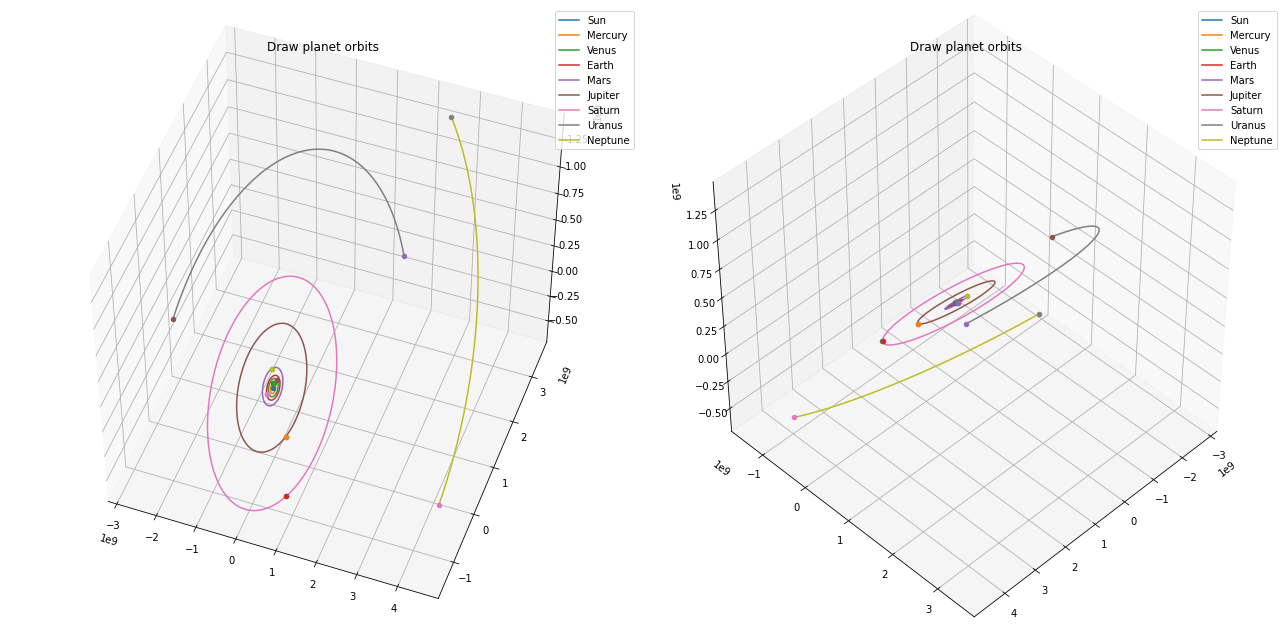

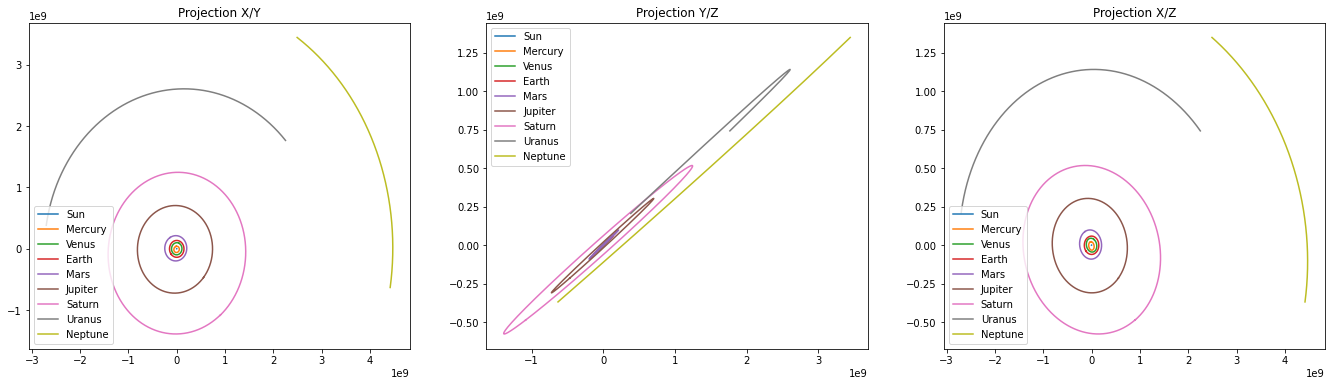

In [ ]:

orbits = get_orbits(datetime.datetime(2021,5,1), planets=ALL_BODIES)
plot_orbits(orbits, title = "Draw planet orbits", interactive=False)

plot_projections(orbits, title = "Draw planet orbits")

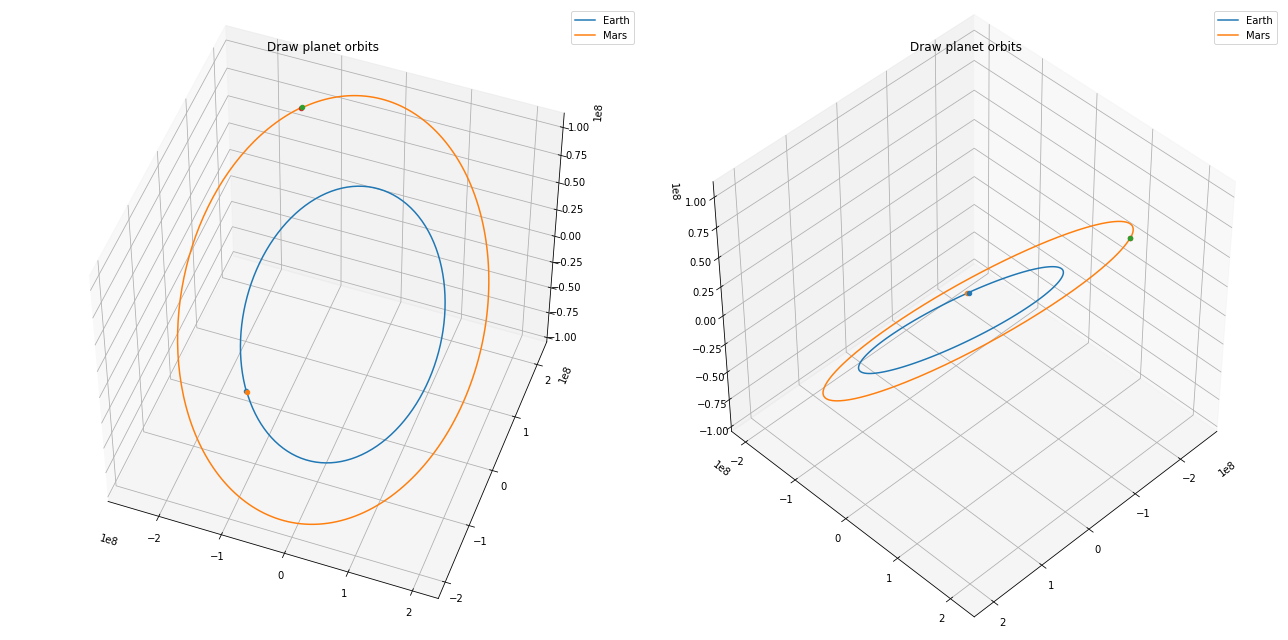

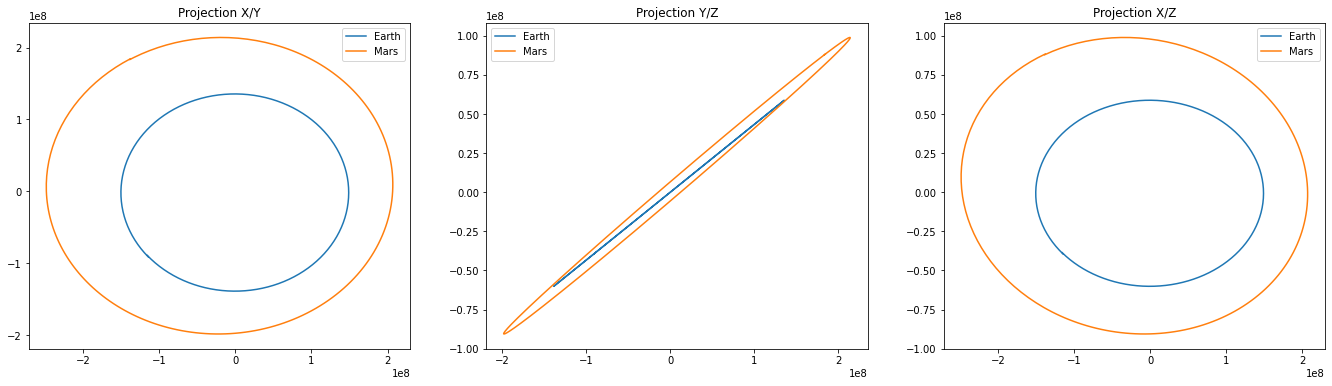

In [ ]:
#selectively plotting orbits of earth and mars
orbits = get_orbits(datetime.datetime(2021,5,1), planets=[EARTH,MARS])
plot_orbits(orbits, title = "Draw planet orbits", interactive=False)

plot_projections(orbits, title = "Draw planet orbits")


## Mission profile

Mission profile classes define the configuration of the simulated flight.

Simulation starts at `timestamp0` (type `datetime`) and can optionally be described using `title` attribute.

Each tragectory starts from the perigee (or apogee) of an Earth orbit. The velocity vector is tangent to the corresponding circular orbit. The orbital plane is aligned with the orbital plane of the Sun-Earth system. The orbit is defined by the

* `angle0` - angle from the far most point from the sun (in °, positive -> forwards)
* `v0` - velocity (in km/s, scalar)
* `orbit0` - height (over sea level).

During the flight instantaneous and continuous events can be planned:

* Separation event (TODO)
* Continuous burn
* Instant burn

Continuous burn requires start mass `mass0` and dry mass `dry_mass` to be defined.

The flight path get sampled at defined rate `sample_dt` (in seconds). The amount of points shouldn't exceed `sample_size`. The flight duration is specified independently from the sample size using attribute `duration` (in seconds).

**Example**

Mission profile:

* Sun/Earth system
* Orbit: circular low earth orbit at 250 km
* Duration: one swing
* Sampling: each second

```
mp = MissionProfile(
    name = "Low Earth orbit at 250km"
    timestamp0 = datetime.datetime(2022, 9, 26),
    v0 = np.sqrt(MU_EARTH / (R_EARTH + 250)),
    orbit0 = 250,
    mass0 = 1000,
    duration = int(np.sqrt(4 * (np.pi**2) * ((R_EARTH + 250)**3) / MU_EARTH)),
    sample_dt = 1,
    sample_size = 6000,
    bodies=[SUN, EARTH]
)
```



In [ ]:
class Event(PrettyPrintable):
    pass

class InstantaneousEvent(Event):
    pass

class ContinuousEvent(Event):
    def calculate_or_get_duration(self, m):
        return self.duration

class Burn(ContinuousEvent):
    def __init__(self,
                 t,                              # Time of event (seconds since t0)
                 duration = None,                # Duration of the burn (seconds)
                 delta_v = None,                 # Intended delta v
                 angle_orbital_plane = 0,        # Angle to v in orbital plane (in °)
                 angle_orbital_plane_normal = 0, # Angle to v perpendicular to orbital plane (in °)
                 flow_rate = RAPTOR_FLOW_RATE * STARSHIP_RAPTOR_COUNT,
                 specific_impulse = RAPTOR_SPECIFIC_IMPULSE,
                 inverse = False):               # Inverse burn direction
        self_assign(self, locals())
        assert (duration is not None) != (delta_v is not None), "Please, provide duration or delta_v"
        if self.delta_v is not None and self.delta_v < 0:
            self.delta_v = -self.delta_v
            self.inverse = True

    def calculate_or_get_duration(self, m):
        if self.duration is not None:
            return self.duration

        delta_m = m - m / np.exp(self.delta_v / (self.specific_impulse * G_EARTH))

        return delta_m / self.flow_rate

class InstantBurn(InstantaneousEvent):
    def __init__(self,
                 t,                               # Time of event (seconds since t0)
                 delta_v = 0,                     # Intended delta v
                 angle_orbital_plane = 0,         # Angle to v in ecliptic plate (in °)
                 angle_orbital_plane_normal = 0): # Angle to v perpendicular to ecliptic (in °)
        self_assign(self, locals())

class Separation(InstantaneousEvent):
    def __init__(self,
                 t,              # Time of event (seconds since t0)
                 delta_m):       # Change in mass (in kg)
        self_assign(self, locals())

class MissionProfile(PrettyPrintable):
    def __init__(self,
                 timestamp0,              # Date and time of the simulation start
                 v0,                      # Initial orbital velocity (in km)
                 mass0,                   # Star mass of the spacecraft
                 orbit0,                  # Initial orbit height (in km)
                 duration,                # Simulation duration (in seconds)
                 sample_size,             # Maximal amount of data points to be gathered
                 title = None,            # Optional description of the simulation
                 dry_mass = 0,            # Dry mass of the ship
                 sample_dt = 60*60,       # Time intervals for orbital parameter sampling (in seconds)
                 angle0 = 0,              # In °
                 bodies = [SUN, EARTH, MARS, JUPITER],
                 events = [],
                 lsoda_nsteps=5000):
        self_assign(self, locals())
        self.events = list(filter(lambda event: (
            not isinstance(event, Burn) or event.delta_v is None or not np.isclose(event.delta_v, 0) 
        ), self.events))
        
    def __repr__(self):
        return pretty_write_dict(self.__dict__)



## Simulation


### Event Manager

Event manager splits the flight into segments where the forces appied to the spacecraft are continuous and though differentiable. Each start and each end of an event will be placed on segment boundaries.

In [ ]:
class EventManager:
    """Configure simulation intervals according to the configured events
    
    Restrictions:
    
    * Times and durations should be int
    * Only one event per time t is currenty supported
    """
    
    def __init__(self, events: List[Event], initial_mass):
        self._events = events
        self._next = 0
        self._current_event = None
        self._begin_interval = 0
        
        self._verify_events()
        self._complete_end_interval(initial_mass)
    
    def _verify_events(self):
        t = 0
        for event in self._events:
            assert t < event.t or np.isclose(t, event.t)
            
            t = event.t
            if isinstance(event, ContinuousEvent):
                if event.duration is not None:
                    assert event.duration > 0
                    t += event.duration
        
    def _complete_end_interval(self, current_mass):
        self._current_event = None

        if self._next >= len(self._events):
            self._end_interval = None
            return
        
        event = self._events[self._next]
        if self._begin_interval < event.t:
            self._end_interval = event.t
            return

        self._next += 1

        if self._begin_interval == event.t:
            self._current_event = event

        if isinstance(event, ContinuousEvent) and self._begin_interval == event.t:
            duration = event.calculate_or_get_duration(current_mass)
            assert not np.isclose(duration, 0) and duration > 0, "Duration to small or negative: " + str(duration)

            self._end_interval = event.t + duration
            
            if self._next < len(self._events):
                next_t = self._events[self._next].t
                assert self._end_interval < next_t or np.isclose(self._end_interval, next_t), \
                    "Calculated duration " + str(duration) + \
                    " sec. for the continuous burn overlaps with the next event at t=" + str(next_t)
            return

        if self._next < len(self._events):
            next_event = self._events[self._next]
            self._end_interval = next_event.t
        else:
            self._end_interval = None

    def next_interval(self, current_mass) -> bool:
        if self._end_interval is None:
            return False

        self._begin_interval = self._end_interval
        
        self._complete_end_interval(current_mass)
        return True
    
    def current_time_interval(self) -> Tuple[int, int]:
        return (self._begin_interval, self._end_interval)

    def current_instantaneous_event(self) -> InstantaneousEvent:
        if isinstance(self._current_event, InstantaneousEvent):
            return self._current_event

        return None
    
    def current_continuous_event(self) -> ContinuousEvent:
        if isinstance(self._current_event, ContinuousEvent):
            return self._current_event

        return None

### Simulation loop

Function: `simulate()`

Simulation loop simulates the flight according to the mission profile. The result of the simulation is returned as `simulation_data` dict.

Simulation result `simulation_data`:

* `mission_profile`: corresponding mission profile
* `sample_size`: (int) amount of collected samples
* `starship_xyz`: (np.ndarray(sample_size, 3)) Sampled starship locations
* `starship_v`: (np.ndarray(sample_size, 3) Sampled starship velocity vectors
* `bodies_xyz`: (dict) {body_id -> (body locations)}
* `bodies_v`: (dict) {body_id -> (body velocities}
* `ecliptic_unit`: unit normal vector to the Sun/Earth ecliptic
* `log`: (True/False) Log status
* `minimal_distances`: (dict) {body_id -> (dict below)}
  * `distance`: minimal distance Starship <-> body
  * `t`: time of the closest distance
  * `body_xyz`: Body xyz of the closes distance to the Starship
  * `starship_xyz': Starship xyz of the closes distance
  * `starship_v`: Starship velocity vectory at the closes distance
  * `starship_mass`: Starship mass at the closes distance



In [ ]:
def calculate_dydt(t, y, mp, em, simulation_data, julian_timestamp0):
    minimal_distances = simulation_data['minimal_distances']
    bodies_r = {
        body: np.array(get_body_xyz(body, julian_timestamp0, t)) for body in mp.bodies
    }
    
    starship_r    = np.array(y[0:3])
    starship_v    = y[3:6]
    starship_mass = y[6]
    
    if starship_mass < mp.dry_mass:
        raise Exception("Out of fuel. t:", t, ", Dry mass: ", mp.dry_mass, ", current mass:", starship_mass)

    starship_a = np.array([0.0, 0.0, 0.0])
    for body in mp.bodies:
        relative_r = starship_r - bodies_r[body]
        relative_norm_r = np.linalg.norm(relative_r)
        starship_a += -relative_r * MU[body] / relative_norm_r**3
        
        minimal_dict = minimal_distances[body]
        if minimal_dict['distance'] > relative_norm_r:
            minimal_dict['distance'] = relative_norm_r
            minimal_dict['t'] = t
            minimal_dict['starship_xyz'] = starship_r
            minimal_dict['starship_v'] = starship_v
            minimal_dict['starship_mass'] = starship_mass
            minimal_dict['body_xyz'] = bodies_r[body]

    dm = 0
    continuous_event = em.current_continuous_event()
    if isinstance(continuous_event, Burn):
        burn = continuous_event
        burn_unit = starship_v / np.linalg.norm(starship_v)
        burn_a = burn_unit * burn.flow_rate / starship_mass * (burn.specific_impulse * G_EARTH)
        
        # Rotate burn_a
        orbital_plane_normal = np.cross(starship_r, starship_v)
        orbital_plane_normal_unit = orbital_plane_normal / np.linalg.norm(orbital_plane_normal)

        starship_v_unit = starship_v / np.linalg.norm(starship_v)

        if burn.angle_orbital_plane != 0:
            rotation = Rotation.from_rotvec(orbital_plane_normal_unit * (burn.angle_orbital_plane * np.pi / 180))
            burn_a = rotation.apply(burn_a)

        if burn.angle_orbital_plane_normal != 0:
            orthogonal = np.cross(starship_v_unit, orbital_plane_normal_unit)
            rotation = Rotation.from_rotvec(orthogonal * (burn.angle_orbital_plane_normal * np.pi / 180))
            burn_a = rotation.apply(burn_a)

        if burn.inverse:
            burn_a = -burn_a
        
        dm = -burn.flow_rate
        starship_a += burn_a

    return np.concatenate([starship_v, starship_a, [dm]])

In [ ]:
def calculate_y0(mp, julian_timestamp0, simulation_data: dict):
    earth_y = get_body_r_v(EARTH, julian_timestamp0, 0)
    sun_xyz = get_body_xyz(SUN, julian_timestamp0, 0)

    earth_xyz = earth_y[0:3] - sun_xyz
    earth_xyz_unit = earth_xyz / np.linalg.norm(earth_xyz)

    earth_v = earth_y[3:6]
    earth_v_unit = earth_v / np.linalg.norm(earth_v)

    ecliptic_unit = np.cross(earth_xyz_unit, earth_v_unit)
    
    simulation_data['ecliptic_unit'] = ecliptic_unit

    starship_xyz = earth_xyz_unit * (R_EARTH + mp.orbit0)
    starship_v = earth_v_unit * mp.v0
    
    if mp.angle0 != 0:
        rotation = Rotation.from_rotvec(ecliptic_unit * (mp.angle0 * np.pi / 180.0))
        starship_xyz = rotation.apply(starship_xyz)
        starship_v = rotation.apply(starship_v)

    xyz_and_v = earth_y + np.concatenate([starship_xyz, starship_v])
    
    return np.concatenate([xyz_and_v, [mp.mass0]])
    
def sample_body_data(mp, sample_bodies_xyz, sample_bodies_v, index, julian_timestamp0, t):
    for body in mp.bodies:
        body_y = get_body_r_v(body, julian_timestamp0, t)
        sample_bodies_xyz[body][index] = body_y[0:3]
        sample_bodies_v[body][index] = body_y[3:6]

def process_instantaneous_event(y, instantaneous_event, simulation_data):
    log = simulation_data['log']
    
    if isinstance(instantaneous_event, InstantBurn):
        burn = instantaneous_event
        if log:
            print("Apply burn event: " + str(burn))
        
        starship_v = y[3:6]
        ecliptic_unit = simulation_data['ecliptic_unit']
        starship_v_unit = starship_v / np.linalg.norm(starship_v)
        delta_v = starship_v_unit * burn.delta_v

        if burn.angle_orbital_plane != 0:
            rotation = Rotation.from_rotvec(ecliptic_unit * (burn.angle_orbital_plane * np.pi / 180))
            delta_v = rotation.apply(delta_v)
        
        if burn.angle_orbital_plane_normal != 0:
            orthogonal = np.cross(starship_v_unit, ecliptic_unit)
            rotation = Rotation.from_rotvec(orthogonal * (burn.angle_orbital_plane_normal * np.pi / 180))
            delta_v = rotation.apply(delta_v)
        y[3:6] = starship_v + delta_v
        
        return y
    assert False, "Unsupported instantaneous event: " + instantaneous_event.__class__.__name__ + \
        " (" + str(instantaneous_event) + ")"
        
def truncate_sampled_data(data, old_size, new_size):
    for key in data:
        value = data[key]
        if isinstance(value, dict):
            truncate_sampled_data(value, old_size, new_size)
            continue
        
        if isinstance(value, np.ndarray) and value.shape[0] == old_size:
            data[key] = value[0:new_size]

def simulate(mp: MissionProfile, log = True, log_progress = False) -> dict:
    if log:
        print(mp)

    time_simulation_start = timer()
        
    simulation_data = {
        'mission_profile': mp,
        'log': log,
        'simulation_start': time_simulation_start
    }

    julian_timestamp0 = get_julian_datetime(mp.timestamp0)
    y0 = calculate_y0(mp, julian_timestamp0, simulation_data)
    
    sample_starship_xyz = np.zeros((mp.sample_size, 3))
    sample_starship_xyz[0] = y0[0:3]
    simulation_data['starship_xyz'] = sample_starship_xyz
    
    sample_starship_v = np.zeros((mp.sample_size, 3))
    sample_starship_v[0] = y0[3:6]
    simulation_data['starship_v'] = sample_starship_v

    sample_starship_m = np.zeros((mp.sample_size))
    sample_starship_m[0] = y0[6]
    simulation_data['starship_m'] = sample_starship_m

    sample_bodies_xyz = {body: np.zeros((mp.sample_size, 3)) for body in mp.bodies}
    simulation_data['bodies_xyz'] = sample_bodies_xyz

    sample_bodies_v = {body: np.zeros((mp.sample_size, 3)) for body in mp.bodies}
    simulation_data['bodies_v'] = sample_bodies_v
    
    simulation_data['minimal_distances'] = {body : {'distance': math.inf} for body in mp.bodies}
    sample_body_data(mp, sample_bodies_xyz, sample_bodies_v, 0, julian_timestamp0, 0)
    
    sample_last_time = 0
    sample_index = 1
    
    REPORTS=10
    next_report = 0

    if log:
        print("Start simulation from " + str(mp.timestamp0))
    em = EventManager(mp.events, initial_mass=mp.mass0)

    y = y0
    while True:
        begin_t, end_t = em.current_time_interval()
        if end_t is None:
            end_t = mp.duration

        instantaneous_event = em.current_instantaneous_event()
        if instantaneous_event is not None:
            y = process_instantaneous_event(y, instantaneous_event, simulation_data)
        
        if log:
            print("Simulate interval: " + str((begin_t, end_t)))

        integrator = ode(calculate_dydt).set_integrator('lsoda', nsteps=mp.lsoda_nsteps)
        integrator.set_initial_value(y, begin_t)
        integrator.set_f_params(mp, em, simulation_data, julian_timestamp0)

        integrator_loop_done = False
        while integrator.successful() and not integrator_loop_done:
            dydt = calculate_dydt(integrator.t, integrator.y, mp, em, simulation_data, julian_timestamp0)
            a = dydt[3:6]
            norm_a = np.linalg.norm(a)
            if np.isclose(norm_a, 0):
                dt = 1
            else:
                dt = min(20 / norm_a, 180)

            if sample_last_time + mp.sample_dt < integrator.t + dt:
                dt = sample_last_time + mp.sample_dt - integrator.t
                
            if integrator.t + dt > end_t:
                dt = end_t - integrator.t
                integrator_loop_done = True
                if dt <= 0:
                    break

            integrator.integrate(integrator.t + dt)

            t = integrator.t
            y = integrator.y
            
            starship_xyz  = y[0:3]
            starship_v    = y[3:6]
            starship_m    = y[6]
            
            if sample_last_time + mp.sample_dt < t or np.isclose(sample_last_time + mp.sample_dt, t):
                sample_last_time = t

                assert sample_index < mp.sample_size, \
                    "To many data to sample. Max sample size: " + str(mp.sample_size) + ", t: " + str(t)

                sample_starship_xyz[sample_index] = starship_xyz
                sample_starship_v[sample_index] = starship_v
                sample_starship_m[sample_index] = starship_m
                
                sample_body_data(mp, sample_bodies_xyz, sample_bodies_v, sample_index, julian_timestamp0, t)
                
                sample_index += 1            
            
            if log and log_progress and next_report < t:
                next_report += mp.duration / REPORTS
                mars_xyz = get_body_xyz(MARS, julian_timestamp0, t)
                print("-------------")
                print("sample_index:", sample_index , "  time:", str(datetime.timedelta(seconds=t)), \
                      "(" + str(t) + ")")
                print("y:", integrator.y)
                print("a:", a)
                print("norm_a:", norm_a)
                print("dt:", dt)
                #print("distance to earth:", np.linalg.norm(earth_results[i]))
                print("distance to mars :", np.linalg.norm(starship_xyz - mars_xyz))

        assert integrator.successful()
        
        if not em.next_interval(starship_m):
            break
        
    truncate_sampled_data(simulation_data, mp.sample_size, sample_index)
    simulation_data['sample_size'] = sample_index

    time_simulation_stop = timer()
    simulation_data['simulation_stop'] = time_simulation_stop
    simulation_data['simulation_time'] = time_simulation_stop - time_simulation_start
    if log:
        if MARS in mp.bodies:
            min_data = simulation_data['minimal_distances'][MARS]

            mars_y = get_body_r_v(MARS, julian_timestamp0, min_data['t'])
            print("Mars1:", mars_y, ", xyz:", min_data['body_xyz'])
            fly_by_delta_v = np.linalg.norm(min_data['starship_v'] - mars_y[3:6])
            print("Minimal distance to mars:", min_data['distance'], \
                  "in ~", min_data['t'] // (60*60*24), "days, fly by delta v", fly_by_delta_v, \
                  "km/s (" + str(min_data) + ")")
        print("Done (" + str(simulation_data['starship_xyz'].shape[0]) + " samples, " \
              + str(datetime.timedelta(seconds=simulation_data['simulation_time'])) + "s)")

    return simulation_data

### Plotting

In [ ]:
def plot_simulation_data_interplanetary(simulation_data, omit_bodies = [JUPITER, SATURN, URANUS, NEPTUNE]):
    mission_profile = simulation_data['mission_profile']

    bodies_xyz = simulation_data['bodies_xyz'].copy()
    for body in omit_bodies:
        bodies_xyz.pop(body, None)

    min_data = simulation_data['minimal_distances'][MARS]
    min_points = np.array([min_data['starship_xyz'], min_data['body_xyz']])

    orbits = get_orbits(mission_profile.timestamp0, planets=bodies_xyz.keys())
    plot_orbits(orbits,
                bodies_xyz,
                simulation_data['starship_xyz'],
                min_points,
                title = mission_profile.title)

    plot_projections(bodies_xyz, {'Starship': simulation_data['starship_xyz']}, min_points)

## Mission - 'optimal delta v' orbit

The goal is to simulate the delta-v optimized transfer orbit from LEO to the Mars. The simulation is based on the precalculated trajectory using from [NASA trajectory browser](https://trajbrowser.arc.nasa.gov/traj_browser.php?maxMag=25&maxOCC=4&chk_target_list=on&target_list=Mars&mission_class=oneway&mission_type=flyby&LD1=2019&LD2=2021&maxDT=1&DTunit=yrs&maxDV=5.5&min=DT&wdw_width=0&submit=Search#a_load_results):

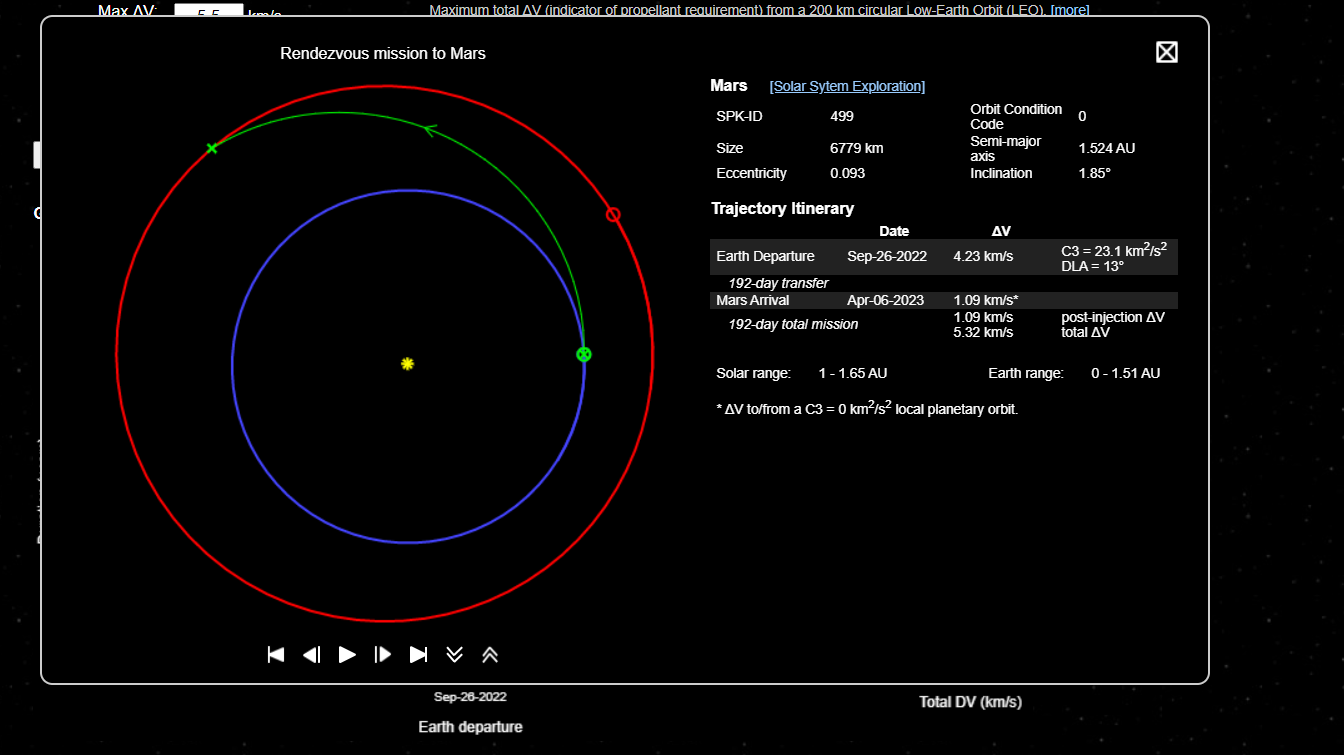


In [ ]:
def get_mission_profile1(angle0, normal_burn_delta_v, delta_t):
    """ Create and return mission profile for mission 1.

    Parameters
    ----------
    angle0
        departure angle in °. 0° - far most from the Sun point of the Earth orbit.
    normal_burn_delta_v
        inclination correction burn at t = 11000000 (~ half way)
    delta_t
        simulation start time correction from 2022-9-26 00:00:00.
    """
    date = datetime.datetime(2022,9,26)
    return MissionProfile(
        title = "Mission 1 - recreate trajectory from NASA trajectory browser:",
        timestamp0 = date +  datetime.timedelta(seconds = delta_t),
        v0 = np.sqrt(MU_EARTH / (200 + R_EARTH)) + 3.88,
        orbit0 = 200,
        mass0 = 1550,
        dry_mass = 120,
        duration = 60 * 60 * 24 * 180,
        sample_dt = 60 * 60,
        sample_size = 24*365*10,
        angle0=angle0,
        bodies = [SUN, EARTH, MARS, JUPITER],
        events = [
            Burn(t = 0,
                delta_v = normal_burn_delta_v,
                angle_orbital_plane_normal=90)
        ]
    )


### ODE optimizer

Use ODE optimizer to find optimal values for
* `angle0`
* `normal_burn_delta`
* `delta_t`

minimizing distance to the Mars.

Using global variable to save data in case of the optimization abort. Optimization is very long running process, that will be most of the time manually cancel. The results can be accessed from the global variables:

* `params_list1` - tuple of parameters
* `result_list1` - distance
* `simulation_data1` - last `len(simulation_data1)` simulation data dicts


[https://www.desmos.com/calculator/pwcnndipo6](#TheoretialAngle)
<a name="TheoretialAngle"></a>

<iframe src="https://www.desmos.com/calculator/ekillnwkdk?embed" width="500px" height="500px" style="border: 1px solid #ccc" frameborder=0></iframe>


In [ ]:
params_list1 = []
result_list1 = []
simulation_data_list1 = []

calc_simulation_data = {}
def calc_minimal_distance1(params):
    #angle0 = -62    # Value from the simulation. Theoretical value is 53.5
    #https://www.desmos.com/calculator/pwcnndipo6
    # https://space.stackexchange.com/questions/45263/optimal-point-in-leo-to-perform-interplanetary-injection-burn
    normal_burn_delta_v, delta_t, angle0 = params
    mission_profile = get_mission_profile1(angle0, normal_burn_delta_v, delta_t)

    simulation_data = simulate(mission_profile, log=False)
    distance = simulation_data['minimal_distances'][MARS]['distance']

    if len(simulation_data_list1) > 5:
        simulation_data_list1.pop(0)

    params_list1.append(params)
    result_list1.append(distance)  
    simulation_data_list1.append(simulation_data)
    print("Distance:",  '{:,}'.format(distance), params)
    return distance

In [ ]:
if True:
    #normal_burn_delta_v, delta_t, angle0
    params = (5.5, 0, -53.5)
    result = minimize(calc_minimal_distance1, params, method='Nelder-Mead', tol=1e-6, 
                      options={'maxiter': None, 'maxfev': None, 'disp': True, 
                               'return_all': False, 'initial_simplex': None, 'xatol': 0.001, 
                               'fatol': 0.001, 'adaptive': True})
    print(result)
    print(result.x)

Distance: 17,939,822.876486894 [  5.5   0.  -53.5]
Distance: 17,736,895.879145857 [  5.775   0.    -53.5  ]
Distance: 17,939,822.876486894 [ 5.50e+00  2.50e-04 -5.35e+01]
Distance: 15,494,447.115094585 [  5.5     0.    -56.175]
Distance: 16,241,966.04478482 [ 5.68333333e+00 -2.50000000e-04 -5.52833333e+01]
Distance: 15,546,190.683839928 [ 5.80555556e+00 -1.66666667e-04 -5.64722222e+01]
Distance: 13,903,875.34000873 [ 5.55092593e+00 -2.77777778e-04 -5.84537037e+01]
Distance: 12,857,502.826826269 [ 5.47623457e+00 -3.70370370e-04 -6.01049383e+01]
Distance: 13,031,731.824037226 [ 5.50452675e+00 -1.08024691e-04 -5.98847737e+01]
Distance: 11,888,123.244863389 [ 5.18161866e+00 -1.52263374e-04 -6.09709191e+01]
Distance: 10,794,778.180593655 [ 4.97363969e+00 -1.47462277e-04 -6.24704847e+01]
Distance: 9,978,439.357062535 [ 5.13626734e+00 -4.17238226e-04 -6.54651311e+01]
Distance: 9,309,850.533770703 [ 5.01502312e+00 -5.56317635e-04 -6.85618414e+01]
Distance: 8,225,527.141897422 [ 4.80540483e+00 

KeyboardInterrupt: ignored

As we have convincing output for Starkicker parameters, we can manually break the minimize function as it takes lot of time for computation.

### Simulation

Here we use results from the ODE optimizer to simulate and plot the final trajectory.

In [ ]:
# These parameters where found by the ODE optimizer (see below)
#3.29583836e+00 -1.00167896e-03 -8.32263692e+01
angle0 = -8.32263318e+01
normal_burn_delta_v = 3.29583836e+00
delta_t = -1.00164905e-03 

mission_profile1 = get_mission_profile1(angle0, normal_burn_delta_v, delta_t)

simulation_data1 = simulate(mission_profile1)

{
	'timestamp0': '2022-09-25 23:59:59.998998',
	'v0': '11.664342809549733',
	'mass0': '1550',
	'orbit0': '200',
	'duration': '15552000',
	'sample_size': '87600',
	'title': 'Mission 1 - recreate trajectory from NASA trajectory browser:',
	'dry_mass': '120',
	'sample_dt': '3600',
	'angle0': '-83.2263318',
	'bodies': [
		'0',
		'3',
		'4',
		'5',

	],
	'events': [
		{
			't': '0',
			'duration': 'None',
			'delta_v': '3.29583836',
			'angle_orbital_plane': '0',
			'angle_orbital_plane_normal': '90',
			'flow_rate': '2.7936',
			'specific_impulse': '382',
			'inverse': 'False',
		},

	],
	'lsoda_nsteps': '5000',
}
Start simulation from 2022-09-25 23:59:59.998998
Simulate interval: (0, 324.6546270576835)
Simulate interval: (324.6546270576835, 15552000)
Mars1: [-1.33604299e+08  1.86035359e+08  8.89361282e+07 -1.94736280e+01
 -1.02256037e+01 -4.16436685e+00] , xyz: [-1.33604299e+08  1.86035359e+08  8.89361282e+07]
Minimal distance to mars: 0.12178239768065915 in ~ 171.0 days, fly by delta v 5

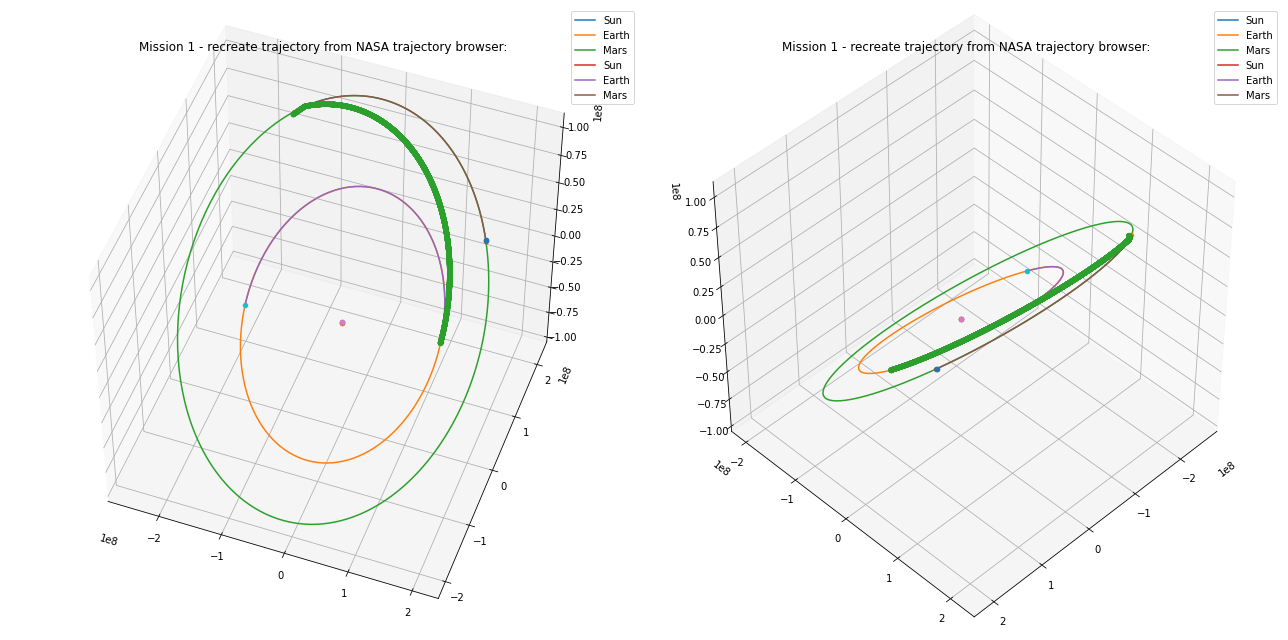

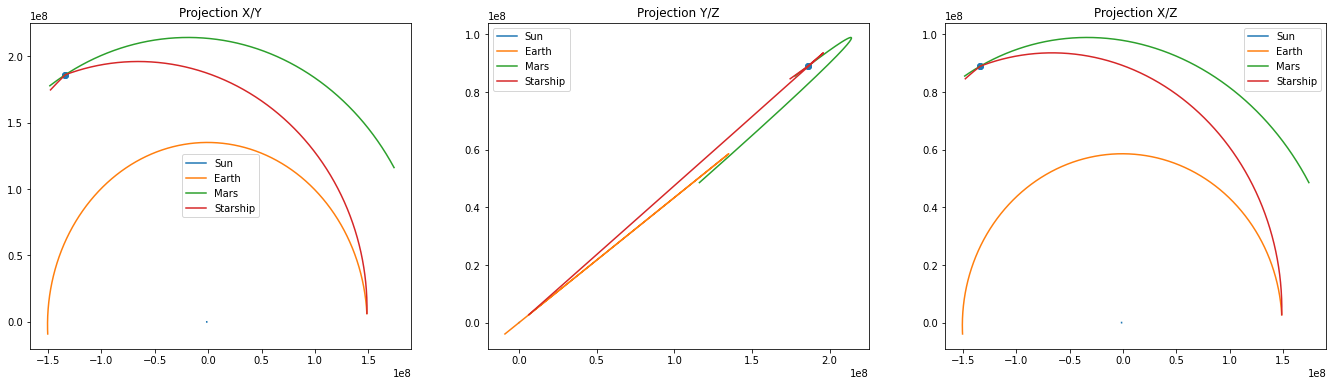

In [ ]:
plot_simulation_data_interplanetary(simulation_data1)